In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

for fname in [
    "uit_viocd.py",
    "transformer_model.py",
    "train1.py"
]:
  open(f"/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/{fname}", "w").close()

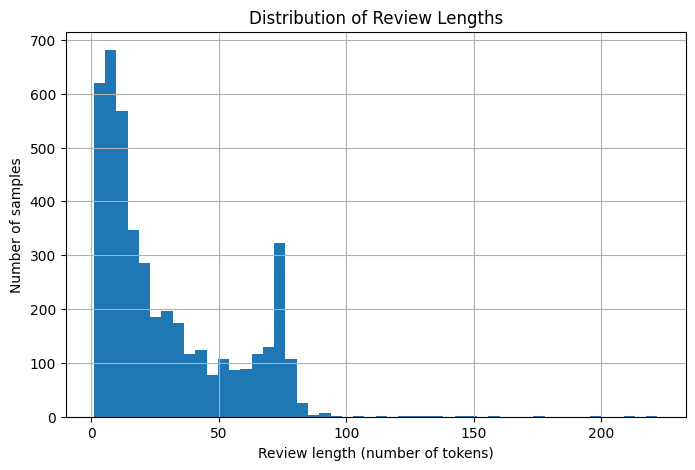

Number of samples: 4387
Min length: 1
Max length: 222
Mean length: 28.759744700250742
Median length: 18.0
95th percentile: 75.0


In [ ]:
import json
import matplotlib.pyplot as plt

#CONFIG
TRAIN_PATH = "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/train.json"

import json

with open(TRAIN_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

# Detect structure
if isinstance(raw, list):
    data = raw
elif isinstance(raw, dict):
    if "data" in raw:
        data = raw["data"]
    else:
        data = list(raw.values())
else:
    raise ValueError("Unsupported JSON format")

# 2. Fake vocab chỉ để tokenize
class DummyVocab:
    def preprocess_sentence(self, s):
        import string
        translator = str.maketrans("", "", string.punctuation)
        return s.lower().translate(translator)

vocab = DummyVocab()

# 3. Tính độ dài từng review
lengths = []

for item in data:
    sentence = item["review"]
    sentence = vocab.preprocess_sentence(sentence)
    tokens = sentence.split()
    lengths.append(len(tokens))

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=50)
plt.xlabel("Review length (number of tokens)")
plt.ylabel("Number of samples")
plt.title("Distribution of Review Lengths")
plt.grid(True)

plt.show()

import numpy as np
lengths = np.array(lengths)

print("Number of samples:", len(lengths))
print("Min length:", lengths.min())
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))
print("95th percentile:", np.percentile(lengths, 95))


In [3]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/uit_viocd.py
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import json
import string
import os

# Special tokens
PAD = "<pad>"

# Vocabulary
class Vocab:
  def __init__(self, paths):
        all_words = set()
        labels = set()

        for filepath in paths:
            data = json.load(open(filepath, "r", encoding="utf-8"))

            # Detect dict vs list format
            if isinstance(data, dict):
                data = list(data.values())

            for item in data:
                sentence = self.preprocess_sentence(item["review"])
                words = sentence.split()
                all_words.update(words)
                labels.add(item["domain"])

        self.w2i = {word: idx for idx, word in enumerate(all_words, start=1)}
        self.w2i["<pad>"] = 0
        self.i2w = {i: w for w, i in self.w2i.items()}

        self.l2i = {label: idx for idx, label in enumerate(sorted(labels))}
        self.i2l = {i: l for l, i in self.l2i.items()}

  @property
  def n_labels(self) -> int:
    return len(self.l2i)

  @property
  def len(self) -> int:
    return len(self.w2i)

  def preprocess_sentence(self, sentence: str) -> str:
    translator = str.maketrans("","", string.punctuation)
    sentence = sentence.lower()
    sentence = sentence.translate(translator)

    return sentence

  def encode_sentence(self, sentence: str) -> torch.Tensor:
    sentence = self.preprocess_sentence(sentence)
    words = sentence.split()
    word_ids = [self.w2i[word] for word in words]

    return torch.Tensor(word_ids).long()

  def encode(self, label:str) -> torch.Tensor:
    label_idx = self.l2i[label]
    return torch.tensor(label_idx)

  def decode(self, label_ids: torch.Tensor) -> str:
    label_ids = label_ids.tolist()
    labels = [self.i2l[idx] for idx in label_ids]

    return labels

# Dataset
class UIT_ViOCD(Dataset):
    def __init__(self, data_dir, vocab):
        self.vocab = vocab
        self.samples = []

        data = json.load(open(data_dir, "r", encoding="utf-8"))

        # Detect dict vs list
        if isinstance(data, dict):
            data = list(data.values())

        for item in data:
            sentence = item["review"]
            domain = item["domain"]

            input_ids = vocab.encode_sentence(sentence)
            label = vocab.encode(domain)

            self.samples.append({
                "input_ids": input_ids,
                "label": label
            })

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx:int):
      return self.samples[idx]

MAX_LEN = 128
# Collate function
def collate_fn(items):
    input_ids = [x["input_ids"][:MAX_LEN] for x in items]
    labels = [item["label"] for item in items]

    # Pad input sequences
    input_ids = pad_sequence(
        input_ids,
        batch_first=True,   # (B, max_len)
        padding_value=0
    )

    mask = (input_ids != 0).long()
    # Stack labels
    labels = torch.stack(labels, dim=0)
    return {
        "input_ids": input_ids,
        "mask": mask,
        "label": labels
    }

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/uit_viocd.py


In [4]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/transformer_model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax để có attention weights
        attn_weights = F.softmax(scores, dim=-1)

        # Weighted sum của values
        output = torch.matmul(attn_weights, V)

        return output, attn_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Tạo ma trận positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Multi-Head Attention components
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(self.d_k)

        # Feed-Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

        # Layer Normalization và Dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Multi-Head Attention
        Q = self.W_Q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Reshape mask cho multi-head attention
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)

        # Scaled Dot-Product Attention
        attn_output, _ = self.attention(Q, K, V, mask)

        # Concat heads và linear projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        attn_output = self.W_O(attn_output)

        # Add & Norm (Residual connection)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-Forward Network
        ffn_output = self.ffn(x)

        # Add & Norm (Residual connection)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff,
                 num_classes, max_len=512, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)

        # Classification head
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        # Embedding + Positional Encoding
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Transformer Encoder
        x = self.encoder(x, mask)

        # Global average pooling
        if mask is not None:
            mask_expanded = mask.unsqueeze(-1).float()
            x = (x * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)
        else:
            x = x.mean(dim=1)

        # Classification
        logits = self.fc(x)

        return logits

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/transformer_model.py


In [5]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train1.py
from uit_viocd import Vocab, collate_fn, UIT_ViOCD
from transformer_model import TransformerModel
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Hàm huấn luyện
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

# Hàm đánh giá
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, predictions, true_labels

# Hàm vẽ biểu đồ
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[0, 2].plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    axes[0, 2].plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    axes[0, 2].set_title('Precision', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Recall
    axes[1, 0].plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    axes[1, 0].plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # F1 Score
    axes[1, 1].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[1, 1].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Summary text
    axes[1, 2].axis('off')
    best_epoch = np.argmax(history['val_acc']) + 1
    summary_text = f"""
    Training Summary
    ─────────────────────────────
    Total Epochs: {len(epochs)}

    Best Validation Results:
    • Epoch: {best_epoch}
    • Accuracy: {max(history['val_acc']):.4f}
    • Precision: {history['val_precision'][best_epoch-1]:.4f}
    • Recall: {history['val_recall'][best_epoch-1]:.4f}
    • F1 Score: {history['val_f1'][best_epoch-1]:.4f}
    • Loss: {history['val_loss'][best_epoch-1]:.4f}

    Final Results:
    • Train Acc: {history['train_acc'][-1]:.4f}
    • Val Acc: {history['val_acc'][-1]:.4f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11,
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    plt.show()

# Hàm load checkpoint
def load_checkpoint(checkpoint_path, model, optimizer=None):
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ Không tìm thấy checkpoint tại: {checkpoint_path}")
        return 0, 0.0, 0.0, None

    print(f"Đang load checkpoint từ: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Đã load model state dict")

    # Load optimizer state
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Đã load optimizer state dict")

    # Lấy thông tin training
    start_epoch = checkpoint.get('epoch', 0)
    best_val_acc = checkpoint.get('val_acc', 0.0)
    best_val_f1 = checkpoint.get('val_f1', 0.0)
    history = checkpoint.get('history', None)

    print(f"\n📋 Thông tin checkpoint:")
    print(f"   • Epoch: {start_epoch}")
    print(f"   • Best Val Accuracy: {best_val_acc:.4f}")
    print(f"   • Best Val F1 Score: {best_val_f1:.4f}")

    if history:
        print(f"   • Đã tìm thấy lịch sử training với {len(history['train_loss'])} epochs")

    return start_epoch, best_val_acc, best_val_f1, history

def check_and_load_checkpoint(checkpoint_path, model, optimizer):
    if os.path.exists(checkpoint_path):
        print(f"\n{'='*60}")
        print(f"Phát hiện checkpoint tại: {checkpoint_path}")
        print(f"{'='*60}")

        checkpoint = torch.load(checkpoint_path)

        print(f"\n📊 Thông tin checkpoint:")
        print(f"   • Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   • Val Accuracy: {checkpoint.get('val_acc', 0.0):.4f}")
        print(f"   • Val F1 Score: {checkpoint.get('val_f1', 0.0):.4f}")

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        start_epoch = checkpoint.get('epoch', 0)
        best_val_acc = checkpoint.get('val_acc', 0.0)
        best_val_f1 = checkpoint.get('val_f1', 0.0)
        history = checkpoint.get('history', None)

        return start_epoch, best_val_acc, best_val_f1, history

    else:
        print(f"\nKhông tìm thấy checkpoint. Bắt đầu training mới...\n")
        return 0, 0.0, 0.0, None

if __name__ == "__main__":
    D_MODEL = 256
    NUM_LAYERS = 3
    NUM_HEADS = 8
    D_FF = 1024
    DROPOUT = 0.1
    BATCH_SIZE = 32
    MAX_LEN = 128
    EPOCHS = 10
    LEARNING_RATE = 0.0001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("="*60)

    vocab = Vocab(paths=["/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/train.json",
                        "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/dev.json",
                        "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/test.json"])
    print("Number of labels:", vocab.n_labels)

    train_dataset = UIT_ViOCD(data_dir='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/train.json', vocab=vocab)
    dev_dataset = UIT_ViOCD(data_dir='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/dev.json', vocab=vocab)
    test_dataset = UIT_ViOCD(data_dir='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/test.json', vocab=vocab)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo mô hình
    print("Khởi tạo mô hình Transformer Encoder (3 lớp)...")

    model = TransformerModel(
        vocab_size=vocab.len,
        d_model=D_MODEL,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_classes=vocab.n_labels,
        max_len=MAX_LEN,
        dropout=DROPOUT
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Tổng số tham số: {total_params:,}")
    print(f"Tham số huấn luyện được: {trainable_params:,}")
    print("="*60)

    # Optimizer và Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # Đường dẫn checkpoint
    checkpoint_path = '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/best_transformer_viocd1.pt'

    # Kiểm tra và load checkpoint nếu có
    start_epoch, best_val_acc, best_val_f1, loaded_history = check_and_load_checkpoint(
        checkpoint_path, model, optimizer
    )

    # Lưu trữ lịch sử huấn luyện
    if loaded_history is not None:
        # Tiếp tục từ history cũ
        history = loaded_history
        print(f"Tiếp tục với lịch sử training từ checkpoint")
    else:
        # Bắt đầu history mới
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_f1': [], 'val_f1': []
        }
        print(f"Khởi tạo lịch sử training mới")

    # Huấn luyện
    print("\nBắt đầu huấn luyện...\n")

    for epoch in range(start_epoch, EPOCHS):
        print(f"{'='*60}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*60}")

        # Train
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validate
        val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels = evaluate(
            model, dev_loader, criterion, device
        )

        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_prec)
        history['val_precision'].append(val_prec)
        history['train_recall'].append(train_rec)
        history['val_recall'].append(val_rec)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # In kết quả
        print(f"\nTraining Metrics:")
        print(f"   Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")

        print(f"\nValidation Metrics:")
        print(f"   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

        # Lưu model tốt nhất
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_f1': val_f1,
                'history': history,  # Lưu cả history
            }, checkpoint_path)
            print(f"\nModel saved! (Best Val Acc: {best_val_acc:.4f}, F1: {best_val_f1:.4f})")

        print()

    print(f"\n{'='*60}")
    print("Hoàn thành huấn luyện!")
    print(f"{'='*60}")
    print(f"\nBest Results:")
    print(f"   Validation Accuracy: {best_val_acc:.4f}")
    print(f"   Validation F1 Score: {best_val_f1:.4f}")

    print(f"{'='*60}")
    print(f"ĐÁNH GIÁ TRÊN TEST")
    test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
            model, test_loader, criterion, device
        )
    # In classification report chi tiết
    print(f"\n{'='*60}")
    print("Classification Report:")
    print(f"{'='*60}")

    label_ids = sorted(vocab.i2l.keys())
    label_names = [vocab.i2l[i] for i in label_ids]

    print(classification_report(
        test_labels,
        test_preds,
        labels=label_ids,
        target_names=label_names,
        digits=4
    ))

    # Vẽ biểu đồ
    plot_training_history(history)

    print(f"Model đã được lưu tại: {checkpoint_path}")

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train1.py


Using device: cuda
Number of labels: 4
Khởi tạo mô hình Transformer Encoder (3 lớp)...
Tổng số tham số: 3,659,012
Tham số huấn luyện được: 3,659,012

Không tìm thấy checkpoint. Bắt đầu training mới...

Khởi tạo lịch sử training mới

Bắt đầu huấn luyện...

Epoch 1/10

Training Metrics:
   Loss: 0.8187 | Acc: 0.6918 | Prec: 0.6809 | Rec: 0.5549 | F1: 0.5439

Validation Metrics:
   Loss: 0.5749 | Acc: 0.7974 | Prec: 0.8437 | Rec: 0.6770 | F1: 0.6619

Model saved! (Best Val Acc: 0.7974, F1: 0.6619)

Epoch 2/10

Training Metrics:
   Loss: 0.4903 | Acc: 0.8256 | Prec: 0.8012 | Rec: 0.7254 | F1: 0.7409

Validation Metrics:
   Loss: 0.4214 | Acc: 0.8613 | Prec: 0.8459 | Rec: 0.7876 | F1: 0.8049

Model saved! (Best Val Acc: 0.8613, F1: 0.8049)

Epoch 3/10

Training Metrics:
   Loss: 0.3694 | Acc: 0.8769 | Prec: 0.8536 | Rec: 0.8036 | F1: 0.8205

Validation Metrics:
   Loss: 0.4056 | Acc: 0.8613 | Prec: 0.8536 | Rec: 0.8075 | F1: 0.8237

Epoch 4/10

Training Metrics:
   Loss: 0.3249 | Acc: 0.887

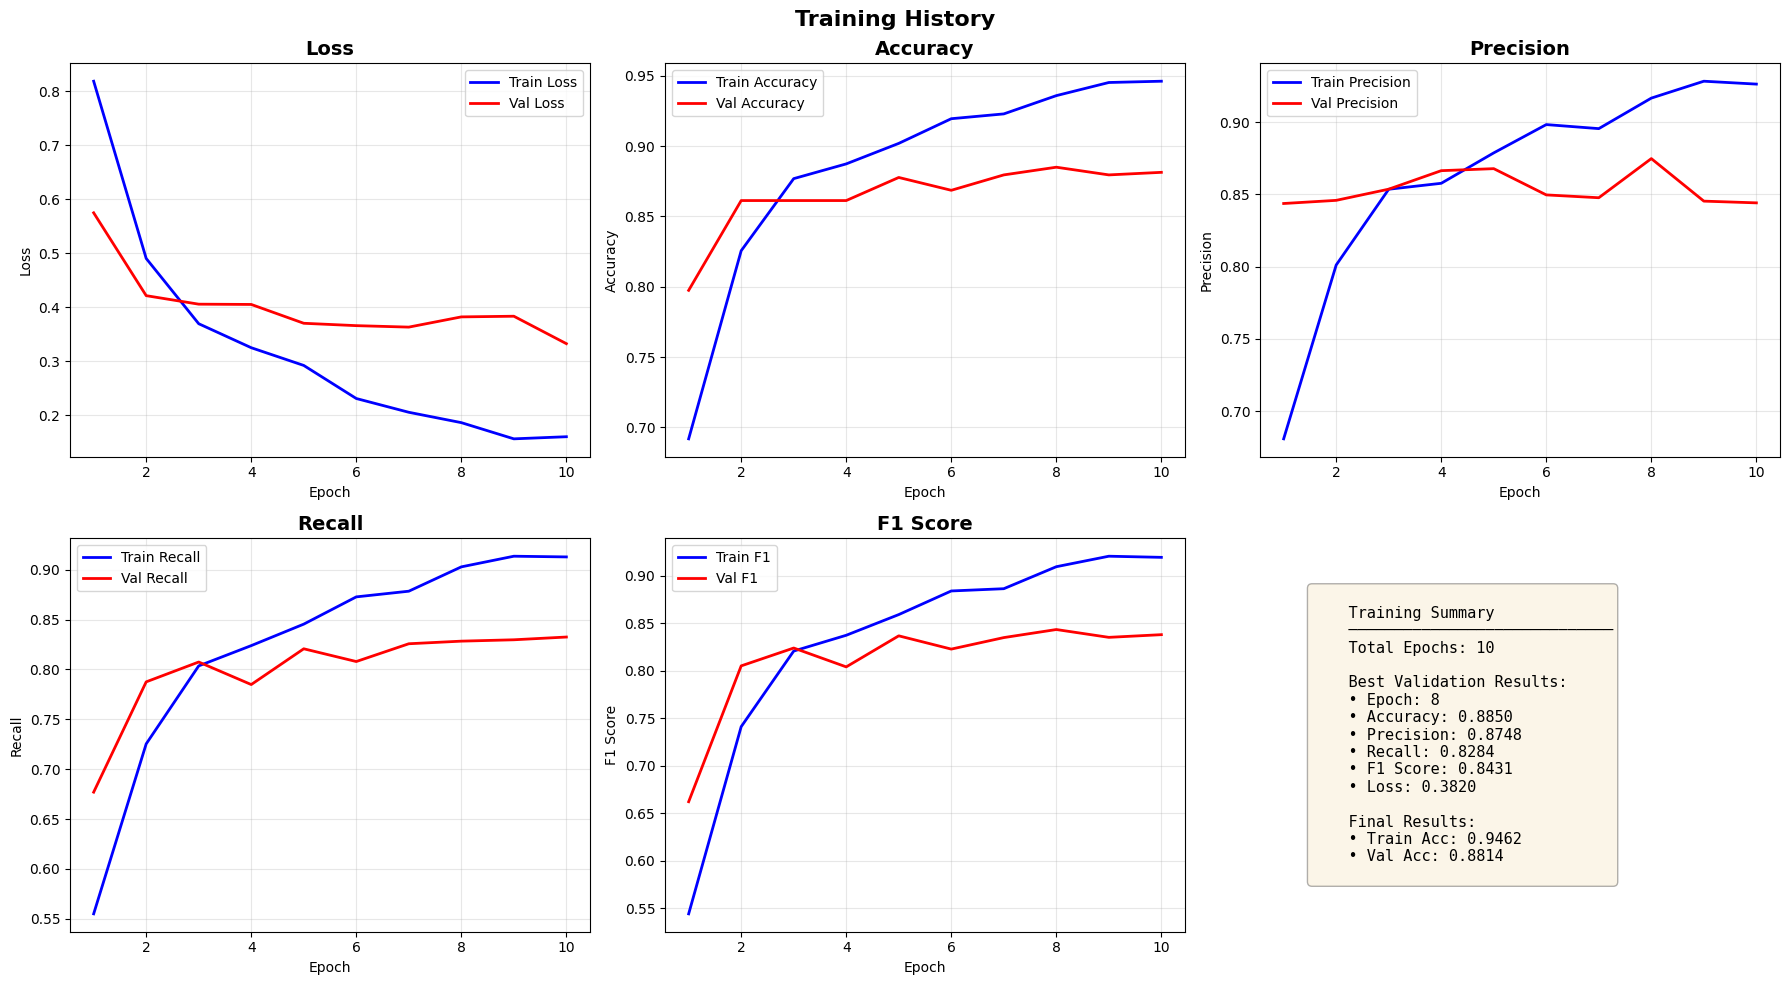

Model đã được lưu tại: /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/best_transformer_viocd1.pt


<Figure size 640x480 with 0 Axes>

In [6]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train1.py')
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train1.py